El porposito de este codigo es analizar la base de datos de la INEGI sobre la cantidad de vehiculos, ya sean autos, motos, camiones o trailers dependiendo del estado en el año 2024

Nos centraremos en hacer una regresion logistica para clasificar la variable AUTOS_PARTICULARES para saber como clasificarlos dependiendo de la cantidad, si es superior a su promedio o no y a su vez ver que tan eficas es y exacto es el modelo que obendremos para al final analizar las variables y ver que tanto y como afecta al modelo.

Empezaremos importando los datos de nuestra base datos que ya esta limpiado, con las variables necesarias eliminando las inecesarias y sin huecos

Una vez importado haremos dumies a nuestra variable de ID_ENTIDAD ya que aunque aparezca como un numero en realidad es una variable categorica, posteriormente añadiermos estas nuevas variables a los datos originales eliminando la variable ID_ENTIDAD sin dumies, para terminar convirtiendo los datos booleanos en numericos.

Ahora analizaremos nuestra variable que queremos predecir la cual es **AUTO_PARTICULAR**, pero esta variable esta como una variable numerica, por lo que la convertiremos a una vairable binaria, sacando su promedio, si el numero es mayor al promedio sera un 1 y si es menor sera un 0.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datos = pd.read_csv("P1-Vehiculos-en-Circulacion-Limpia.csv")

dummies = pd.get_dummies(datos['ID_ENTIDAD'])
datos = pd.concat([datos, dummies], axis=1)
datos = datos.drop(columns='ID_ENTIDAD')
datos = datos.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

promedio=datos['AUTO_PARTICULAR'].mean()
promedio = round(promedio)
print("Valor promedio: ",promedio)

CantidadAutos=datos['AUTO_PARTICULAR']>promedio
datos=datos.drop(columns='AUTO_PARTICULAR')
CantidadAutos = CantidadAutos.astype(int)


datos = pd.concat([datos,CantidadAutos],axis=1)
datos = datos.rename(columns={'AUTO_PARTICULAR': 'CANTIDAD_AUTOS'})
print("\n",CantidadAutos)
print(CantidadAutos.value_counts())
datos.head()

Valor promedio:  15690

 0       1
1       0
2       0
3       0
4       1
       ..
2473    0
2474    0
2475    1
2476    0
2477    0
Name: AUTO_PARTICULAR, Length: 2478, dtype: int64
AUTO_PARTICULAR
0    2195
1     283
Name: count, dtype: int64


,AUTO_OFICIAL,AUTO_PUBLICO,CAM_PAS_OFICIAL,CAM_PAS_PUBLICO,CAM_PAS_PARTICULAR,CYC_CARGA_OFICIAL,CYC_CARGA_PUBLICO,CYC_CARGA_PARTICULAR,MOTO_OFICIAL,MOTO_DE_ALQUILER,...,24,25,26,27,28,29,30,31,32,CANTIDAD_AUTOS
0,452,4741,5,2497,619,557,3599,112480,299,0,...,0,0,0,0,0,0,0,0,0,1
1,0,36,0,2,18,6,20,5689,2,0,...,0,0,0,0,0,0,0,0,0,0
2,1,168,0,7,10,18,4,13383,9,0,...,0,0,0,0,0,0,0,0,0,0
3,2,21,0,0,6,7,0,1795,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24,243,0,46,90,35,180,17078,24,0,...,0,0,0,0,0,0,0,0,0,1


Esto nos arroja ahora una base de datos con 44 variables diferentes, con los dummies y la nueva variable cualitativa binaria que analizaremos.
Tambien podemos observar que hay muchos datos que son 0 y pocos datos que son 1, aunque no lo suficientemente pocos para considerarlo una mala medida, por lo que seguiremos con estos datos asi distribuidos observando que tan bien clasifica.

Ahora realizaremos una division de los datos en entrenamiento y prueba en una proporcion de 80/20. A su vez para que sus datos binarios se mantegan proporcionales usaremos el comando srtatify que sea igual a nuestra variable de salida

In [3]:
from sklearn.model_selection import train_test_split

X=datos.drop("CANTIDAD_AUTOS",axis=1)
Y=datos.CANTIDAD_AUTOS

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = .8,stratify=Y)
print("---Cantidad de clases en los datos originales:")
print(Y.value_counts())
distribucion=Y.value_counts()/Y.value_counts().sum()*100
print("\nDistibucion de clases en los datos originales")
print(distribucion)
print("\n---Cantidad de clases en los datos de entrenamiento:")
print(Y_train.value_counts())
distribucion_train=Y_train.value_counts()/Y_train.value_counts().sum()*100
print("\nDistribucion de clases en los datos de entrenamiento:")
print(distribucion_train)
print("\n---Cantidad de clases en los datos de prueba:")
print(Y_test.value_counts())
distribucion_test=Y_test.value_counts()/Y_test.value_counts().sum()*100
print("\nDistribucion de clases en los datos de prueba:")
print(distribucion_test)


---Cantidad de clases en los datos originales:
CANTIDAD_AUTOS
0    2195
1     283
Name: count, dtype: int64

Distibucion de clases en los datos originales
CANTIDAD_AUTOS
0    88.5795
1    11.4205
Name: count, dtype: float64

---Cantidad de clases en los datos de entrenamiento:
CANTIDAD_AUTOS
0    1756
1     226
Name: count, dtype: int64

Distribucion de clases en los datos de entrenamiento:
CANTIDAD_AUTOS
0    88.597376
1    11.402624
Name: count, dtype: float64

---Cantidad de clases en los datos de prueba:
CANTIDAD_AUTOS
0    439
1     57
Name: count, dtype: int64

Distribucion de clases en los datos de prueba:
CANTIDAD_AUTOS
0    88.508065
1    11.491935
Name: count, dtype: float64


Como podemos observar desde los datos originales de Y hasta los de entrenamiento y prueba se amntiene en una proporcion aproximada de 88% y 12% por lo que su separacion sera buena para trabajar.

Lo siguiente que haremos es medir la exactitud del modelo el Acurracy mediante validaacion cruzada, en esta ocacion lo haremos con solo 5 caracteristicas seleccionadas por nosotros para mayor eficacia y haremos otra vez una separacion de los datos en train y test.

Nuestra base datos al momento de hacer dummies se generaron mal los nombres de las variables quedandose como si fuera un valor numerico, por lo que con el comando astype(str) y enfocandonos en las columnas los convertiremos a string para poder trabajar con estas variables.

Ahora si genereraremos un modelo de regresio logistica con estas 5 caracteristicas y para minimizar el efecto causado por el desbalance de clases, también definiremos class_weight="balanced".

Para terminar esta parte con la funcion cross_val_score podremos sacar el valor de la exactitud del modelo y a su vez a esa exactitud le sacaremos el promedio, teniendo su exactitud.



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

caracteristicas=['AUTO_OFICIAL', 'CYC_CARGA_PARTICULAR', 'MOTO_PARTICULAR', 'AUTO_PUBLICO', 'CAM_PAS_PARTICULAR']
datos_caracteristicas=[caracteristicas+['CANTIDAD_AUTOS']]
X5=datos[caracteristicas]
Y5=datos.CANTIDAD_AUTOS

X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5,Y5, train_size = .8,stratify=Y5)

X5_train.columns = X5_train.columns.astype(str)
X5_test.columns = X5_test.columns.astype(str)

model5 = LogisticRegression(class_weight="balanced",max_iter=2000)
results5=model5.fit(X5_train,Y5_train)


Exactitud5 = cross_val_score(results5, X5_train, Y5_train, cv=5)

Exactitud5_promedio = Exactitud5.mean()
print("\nLa exactitud del modelo con 5 caracteristicas: ", Exactitud5_promedio)


La exactitud del modelo con 5 caracteristicas:  0.9500496145332417


Nos da una Exactitud del 95% (aproximadamente) por lo que podemos decir que minimo con estas 5 caracterisiticas el modelo funciona bastante bien para predecir nuesta Cantidad de Autos si son arriba o no del promedio.

Por lo que ahora realizaremos este mismo proceso pero ahora para todas las variables usando los datos de entrenamiento que establecimos antes de usar las 5 caracteristicas.

Usando este modelo de todas las variables, generaemos un vector
de probabilidades para los datos de prueba. A su vez generaremos varias matrices de confusión con diferentes umbrales usando la funcion ConfusionMatrixDisplay y a su vez de cada umbral la exactitud, sensibilidad y especificidad.
Para calcualr la exactitud y la sensibilidad usaremos las funciones accuracy_score y recall_score respectivamentes, pero para la especificidad lo haremos emdiante la formula de esta misma, sacando los valores numerica de las matrices de confusion con el comando ravel().

Los umbrales que haremos seran de 0.5, uno
mayor en este caso 0.8, y uno menor en este caso 0.2.
Utilizaremos estos umbrales tan lejanos del 0.5 que sera nuestra media y el valor mas correcto, para analizar que tanto cambiaria nuestra matriz de confusion si damos prioridad clara a que prediga mas 1 o 0.


La exactitud del modelo con validacion cruzada:  0.9677047553621861 


--- Umbral: 0.5 ---
Matriz de Confusion:


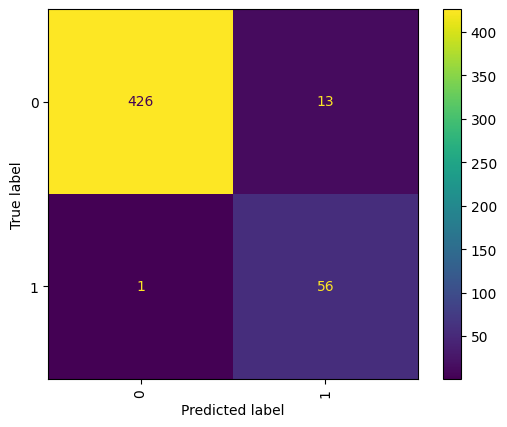

Exactitud: 0.9717741935483871
Sensibilidad: 0.9824561403508771
Especificidad: 0.9703872437357631

--- Umbral: 0.8 ---
Matriz de Confusion:


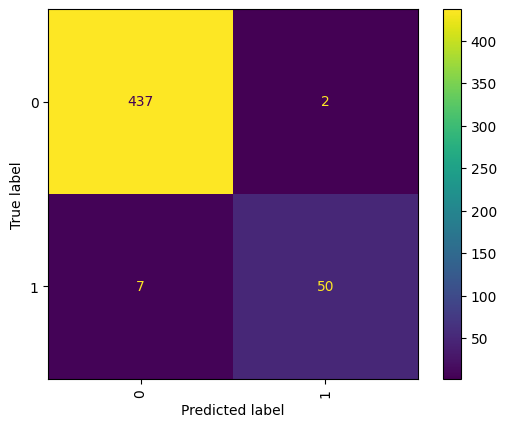

Exactitud: 0.9818548387096774
Sensibilidad: 0.8771929824561403
Especificidad: 0.9954441913439636

--- Umbral: 0.2 ---
Matriz de Confusion:


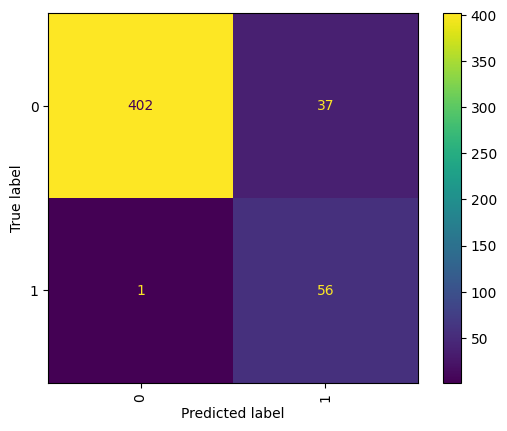

Exactitud: 0.9233870967741935
Sensibilidad: 0.9824561403508771
Especificidad: 0.9157175398633257


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay as cmd

from sklearn.preprocessing import StandardScaler

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(class_weight="balanced",max_iter=2000)
results=model.fit(X_train_scaled,Y_train)

Exactitud_cruzada = cross_val_score(results, X_train_scaled, Y_train, cv=5)

Exactitud_cruzada_promedio = Exactitud_cruzada.mean()
print("\nLa exactitud del modelo con validacion cruzada: ",Exactitud_cruzada_promedio,"\n")

Y_pred_prob = results.predict_proba(X_test_scaled)[:, 1]

umbral = [0.5, 0.8, 0.2]

for umbral in umbral:
    print("\n--- Umbral:", umbral, "---")
    Y_pred = (Y_pred_prob >= umbral).astype(int)

    cm = confusion_matrix(Y_test, Y_pred)
    matrises=cmd(cm, display_labels=results.classes_).plot(xticks_rotation="vertical")
    print("Matriz de Confusion:")
    plt.show()

    Exactitud = accuracy_score(Y_test, Y_pred)
    Sensibilidad = recall_score(Y_test, Y_pred)
    tn, fp, fn, tp = cm.ravel()
    Especificidad = tn / (tn + fp)

    print("Exactitud:", Exactitud)
    print("Sensibilidad:", Sensibilidad)
    print("Especificidad:", Especificidad)

Podemos observar que estos 3 umbrales y con validacion cruzada tienen los 4 un valor aproximado de 95% para la exactitud o incluso mas, por lo que nuestro modelos realmente predice muy bien los 0 e incluso los 1. Aunque tambien puede deberse a que la cantidad de 1 no son demaciados en la base de datos, por lo que para tener una mejor confianza de estos de estos datos seria necesario tener mas 1.

Para ver esto de una forma mas clara, realizaremos una grafica de Curva ROC con las funciones roc_auc_score, roc_curve, auc. Tanto para graficar como para obtener los valores de ROC y de AUC que nod dirfan que tan eficiente es nuestro modelos prediciendo valores de nuestros valores de prueba


Valor de AUC: 0.9970826839307836


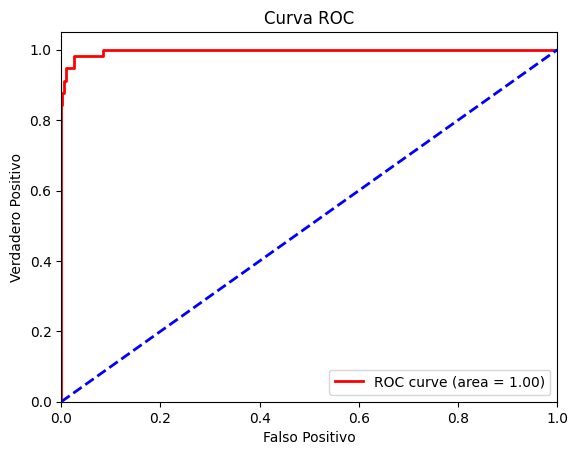

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
auc_valor=roc_auc_score(Y_test, Y_pred_prob)
print("Valor de AUC:", auc_valor)

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc=auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()

Como podemos observar la area de ROC es de 1 o muy cercana a 1, ya que como observarmos mas detalladamente en en valor de AUC no es exactamente 1 pero si muy cercana a 1 siendo de 0.9955 por lo que nos indica que este modelopuede predecir muy bien los 0 y 1 de nuestra variable de CANTIDAD_AUTOS

Ahora para terminar el codigo imprimiremos los coeficientes y los Odds para saber como se comportan las variables y cuales afectan mas a la regresion logistica.


In [7]:
tabla_coef = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model.coef_[0],
}).sort_values(by="Coeficiente", ascending=False)
tabla_coef['Odss (Momios)']=np.exp(tabla_coef['Coeficiente'])

print(tabla_coef)

                Variable  Coeficiente  Odss (Momios)
7   CYC_CARGA_PARTICULAR     6.743152     848.230522
10       MOTO_PARTICULAR     3.418071      30.510490
1           AUTO_PUBLICO     1.815716       6.145476
3        CAM_PAS_PUBLICO     1.552246       4.722065
5      CYC_CARGA_OFICIAL     1.366712       3.922434
0           AUTO_OFICIAL     0.794402       2.213117
39                    29     0.524187       1.689086
25                    15     0.509552       1.664545
6      CYC_CARGA_PUBLICO     0.462659       1.588292
27                    17     0.448722       1.566309
19                     9     0.441875       1.555621
36                    26     0.418393       1.519518
29                    19     0.404406       1.498413
22                    12     0.376560       1.457263
15                     5     0.265343       1.303878
13                     3     0.200291       1.221758
38                    28     0.179414       1.196516
8           MOTO_OFICIAL     0.179393       1.

Como podemos observar la variable mas influyente es la de CYC_CARGA_PARTICULAR siguiendo la de MOTO_PARTICULAR siendo que por cada vez que aumentan los dagtos de estas variables la propabilidad o mas bien dicho los momios de que se produzca correctamente los 0 y 1 de los AUTO_PARTICULAR que despues convertimos a CANTIDAD_AUTOS aumente  significativamente.
Los demas coeficientes aunque si aumentan las probabilidades ya no son tan impactactantes como estas 2 primeras, pero aun asi ayudan al modelo a ser exacto.
Tambien podemos observar que hay coeficientes negativas que no modifican la probabilidad de obtener unos.

Sin embargo tenemos en cuenta que la mayoria de variables ayudan al sistema a predecir de mejor manera, la obtencion de 0 y 1 como lo vimos en las matrices de confución.